In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, mean_squared_error, r2_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap

In [4]:
df = pd.read_csv('/Users/anany/OneDrive/Desktop/SEM2/6302-machine learning/data.csv')

In [5]:
# create a copy of the dataset
df_logistic = df.copy()

In [6]:
missing_values = df_logistic.isnull().sum()
print(missing_values)

y           0
x1          0
x2          0
x3          0
x4          0
        ...  
x96      6638
x97         0
x98         0
x99     12836
x100        0
Length: 101, dtype: int64


In [7]:
# separate features and target
X = df_logistic.drop(columns=['y'])
y = df_logistic['y']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify column datatypes
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# Create pipeline for logistic regression
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, solver="liblinear"))
])

# Fit model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['x1', 'x2', 'x4', 'x5', 'x6',
                                                   'x8', 'x9', 'x10', 'x11',
                                                   'x12', 'x13', 'x14', 'x15',
                                                   'x16', 'x17', 'x18', 'x20',
                                                   'x21', 'x22', 'x23', 'x25',
                                                   'x26', 'x27', 'x28', 'x29',
                                                   'x30', 'x32', 'x34', 'x35',
                                                   'x36', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['x3', 'x7', 'x19', 'x24',
                                                   'x31', 'x33', 'x39', 'x60',
                                                   'x65', 'x77', 'x93',
                                                   'x99'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, solver='liblinear'))])

Metrics of logistic regression:
Accuracy:  0.7452
Precision: 0.2521
Recall:    0.4028
F1 Score:  0.3101
AUC Score: 0.6523

Confusion Matrix:
[[5504 1359]
 [ 679  458]]


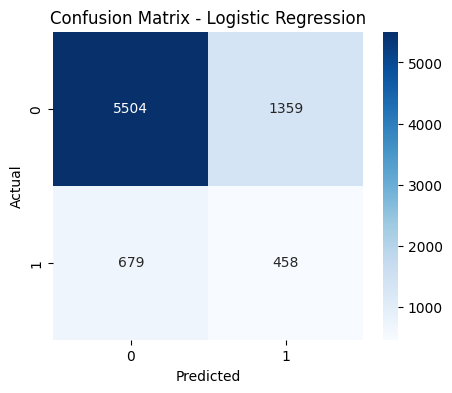

Classification Report - Logistic Regression:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84      6863
           1       0.25      0.40      0.31      1137

    accuracy                           0.75      8000
   macro avg       0.57      0.60      0.58      8000
weighted avg       0.80      0.75      0.77      8000



In [23]:
# Predictions and probabilities
y_pred_lr = pipeline.predict(X_test)
y_proba_lr = pipeline.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("Metrics of logistic regression:")
accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy:  {accuracy:.4f}")
precision = precision_score(y_test, y_pred_lr, zero_division=0)
print(f"Precision: {precision:.4f}")
recall = recall_score(y_test, y_pred_lr, zero_division=0)
print(f"Recall:    {recall:.4f}")
f1 = f1_score(y_test, y_pred_lr, zero_division=0)
print(f"F1 Score:  {f1:.4f}")
auc = roc_auc_score(y_test, y_proba_lr)
print(f"AUC Score: {auc:.4f}")

# CONFUSION MATRIX
print("\nConfusion Matrix:")
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(cm_lr)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Classification Report - Logistic Regression:")
print(classification_report(y_test, y_pred_lr))



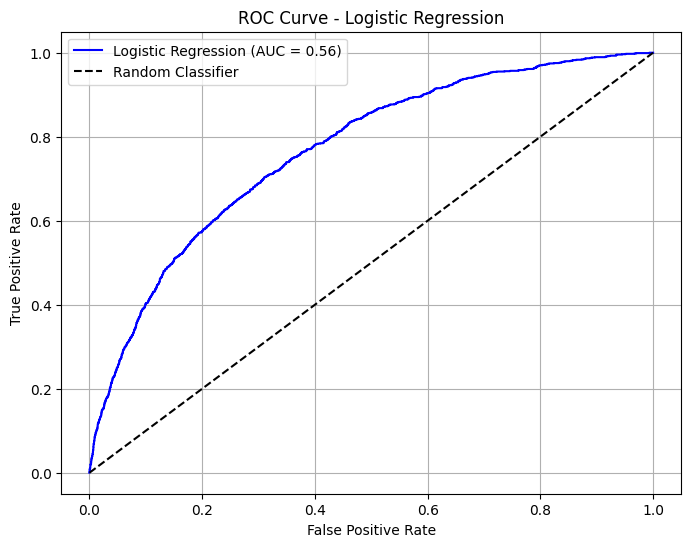

In [14]:

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_lr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid()
plt.show()

In [15]:
# Top 3 most important features
# Get feature names after encoding
feature_names_num = numerical_cols
feature_names_cat = pipeline.named_steps["preprocessor"].transformers_[1][1] \
    .named_steps["onehot"].get_feature_names_out(categorical_cols)
all_features = np.concatenate([feature_names_num, feature_names_cat])

# Get coefficients
coefs = pipeline.named_steps["classifier"].coef_[0]
feature_importance = pd.Series(coefs, index=all_features).sort_values(key=abs, ascending=False)

print("\nTop 3 Important Features (by absolute coefficient):")
print(feature_importance.head(3))


Top 3 Important Features (by absolute coefficient):
x7_-0.03%        2.056031
x7_0.03%        -1.728255
x19_($873.63)    1.521945
dtype: float64


Metrics for Decision Tree:
Accuracy:  0.7730
Precision: 0.2286
Recall:    0.2515
F1 Score:  0.2395
AUC Score: 0.5555

Confusion Matrix - Decision Tree:
[[5898  965]
 [ 851  286]]


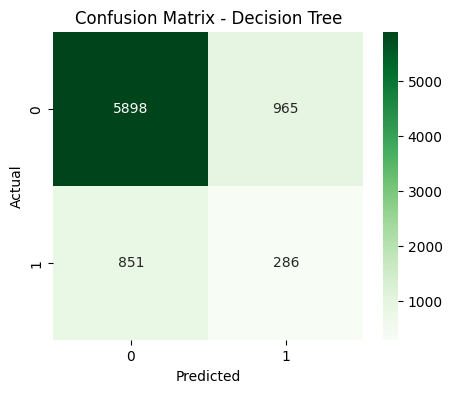

Classification Report - Decision Tree:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      6863
           1       0.23      0.25      0.24      1137

    accuracy                           0.77      8000
   macro avg       0.55      0.56      0.55      8000
weighted avg       0.78      0.77      0.78      8000



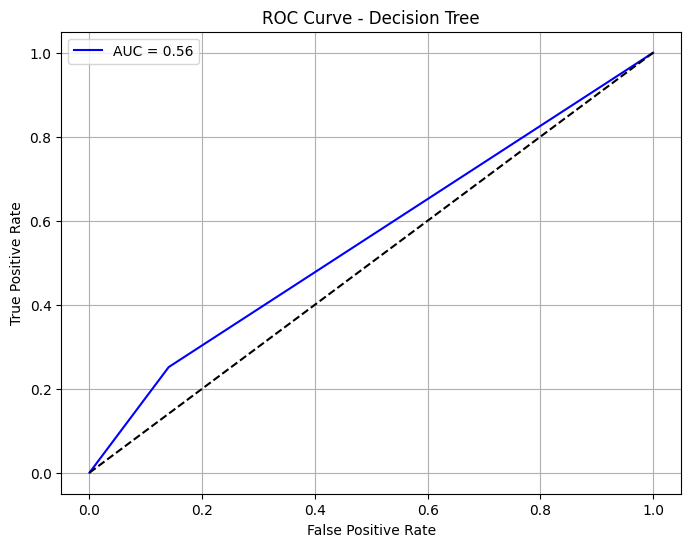


Top 3 Important Features:
x7     0.053394
x4     0.050354
x47    0.030334
dtype: float64


In [24]:
# Separate features and target
X = df.drop(columns=['y'])
y = df['y']

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Fill missing values in categorical columns with mode
X[categorical_cols] = X[categorical_cols].fillna(X[categorical_cols].mode().iloc[0])

# Encode categorical columns with LabelEncoder
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le  # Save encoders in case you need inverse_transform later

# Fill missing values in numeric columns with median
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Predict
y_pred_dt = dt.predict(X_test)
y_proba_dt = dt.predict_proba(X_test)[:, 1]

# Metrics
print("Metrics for Decision Tree:")
accuracy = accuracy_score(y_test, y_pred_dt)
print(f"Accuracy:  {accuracy:.4f}")
precision = precision_score(y_test, y_pred_dt, zero_division=0)
print(f"Precision: {precision:.4f}")
recall = recall_score(y_test, y_pred_dt, zero_division=0)
print(f"Recall:    {recall:.4f}")
f1 = f1_score(y_test, y_pred_dt, zero_division=0)
print(f"F1 Score:  {f1:.4f}")
auc = roc_auc_score(y_test, y_proba_dt)
print(f"AUC Score: {auc:.4f}")

# confusion matrix
print("\nConfusion Matrix - Decision Tree:")
cm_dt = confusion_matrix(y_test, y_pred_dt)
print(cm_dt)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Classification Report - Decision Tree:")
print(classification_report(y_test, y_pred_dt))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_dt)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}", color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree")
plt.legend()
plt.grid()
plt.show()

# Top 3 important features
feature_importance = pd.Series(dt.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 3 Important Features:")
print(feature_importance.head(3))

Metrics for Random Forest
Accuracy:  0.8580
Precision: 0.5556
Recall:    0.0044
F1 Score:  0.0087
AUC Score: 0.7207

Confusion Matrix - Random Forest:
[[6859    4]
 [1132    5]]


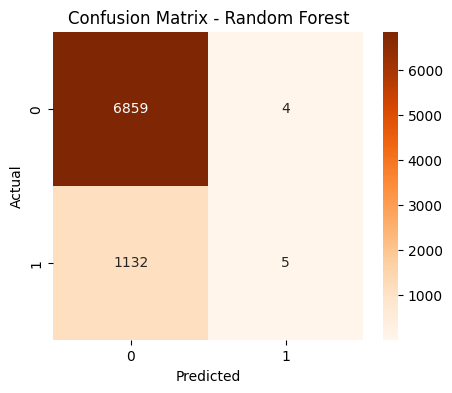

Classification Report - Random Forest:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      6863
           1       0.56      0.00      0.01      1137

    accuracy                           0.86      8000
   macro avg       0.71      0.50      0.47      8000
weighted avg       0.82      0.86      0.79      8000



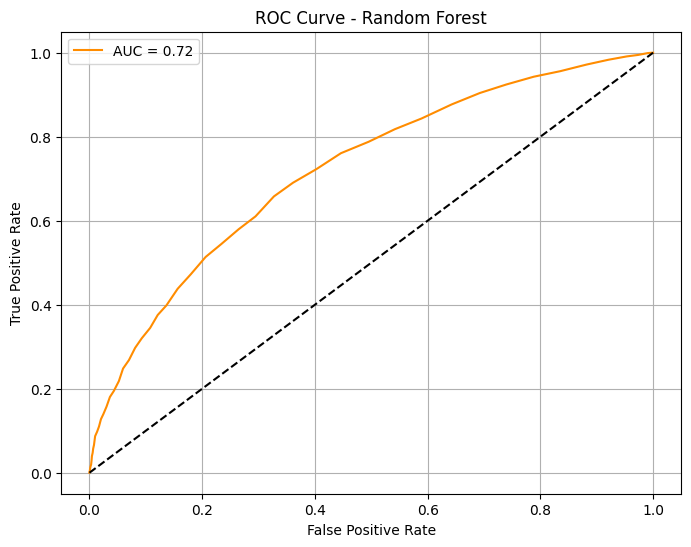


Top 3 Important Features:
x7     0.039659
x4     0.028608
x47    0.020497
dtype: float64


In [25]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# Evaluation Metrics
print("Metrics for Random Forest")
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy:  {accuracy:.4f}")
precision = precision_score(y_test, y_pred_rf, zero_division=0)
print(f"Precision: {precision:.4f}")
recall = recall_score(y_test, y_pred_rf, zero_division=0)
print(f"Recall:    {recall:.4f}")
f1 = f1_score(y_test, y_pred_rf, zero_division=0)
print(f"F1 Score:  {f1:.4f}")
auc = roc_auc_score(y_test, y_proba_rf)
print(f"AUC Score: {auc:.4f}")


# confusion matrix
print("\nConfusion Matrix - Random Forest:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(cm_rf)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Classification Report - Random Forest:")
print(classification_report(y_test, y_pred_rf))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid()
plt.show()

# Top 3 Important Features
feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 3 Important Features:")
print(feature_importance.head(3))



c:\Users\anany\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [20:14:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for XGBoost
Accuracy:  0.8631
Precision: 0.5905
Recall:    0.1205
F1 Score:  0.2001
AUC Score: 0.7936

Confusion Matrix - XGBoost:
[[6768   95]
 [1000  137]]


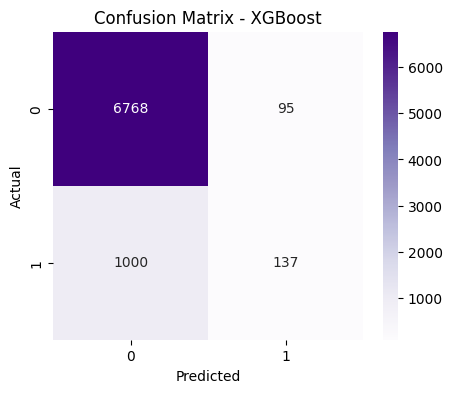

Classification Report - XGBoost:
              precision    recall  f1-score   support

           0       0.87      0.99      0.93      6863
           1       0.59      0.12      0.20      1137

    accuracy                           0.86      8000
   macro avg       0.73      0.55      0.56      8000
weighted avg       0.83      0.86      0.82      8000



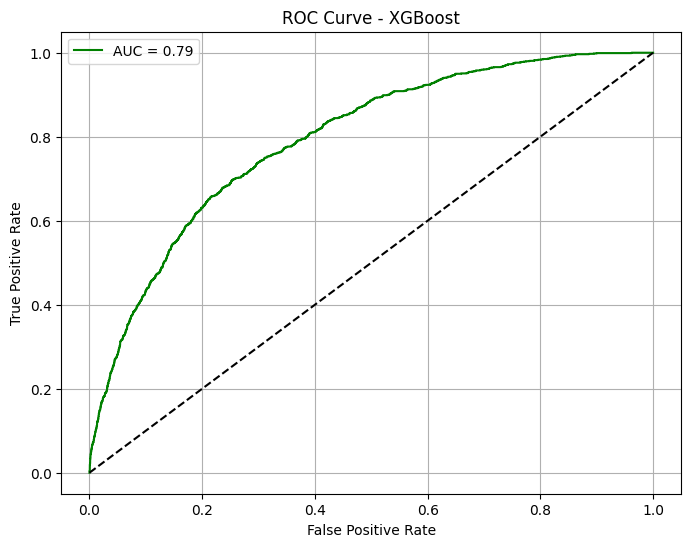

In [26]:
# Train XGBoost
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42)
# Handling any label-related warnings with use_label_encoder=False
# eval_metric='logloss' to suppress unnecessary logs
xgb.fit(X_train, y_train)

# Predict
y_pred_xg = xgb.predict(X_test)
y_proba_xg = xgb.predict_proba(X_test)[:, 1]

# Evaluation Metrics
print("Metrics for XGBoost")
accuracy = accuracy_score(y_test, y_pred_xg)
print(f"Accuracy:  {accuracy:.4f}")
precision = precision_score(y_test, y_pred_xg, zero_division=0)
print(f"Precision: {precision:.4f}")
recall = recall_score(y_test, y_pred_xg, zero_division=0)
print(f"Recall:    {recall:.4f}")
f1 = f1_score(y_test, y_pred_xg, zero_division=0)
print(f"F1 Score:  {f1:.4f}")
auc = roc_auc_score(y_test, y_proba_xg)
print(f"AUC Score: {auc:.4f}")

#confusion matrix
print("\nConfusion Matrix - XGBoost:")
cm_xgb = confusion_matrix(y_test, y_pred_xg)
print(cm_xgb)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Classification Report - XGBoost:")
print(classification_report(y_test, y_pred_xg))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_xg)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}", color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.grid()
plt.show()



#### Top 3 features based on how often they appear in splits and how helpful those splits are.
#### SHAP value shows how much a feature contributed to the model’s prediction for each individual row

#### SHAP (Shapley Additive explanations) is a game-theory-based method to explain predictions of machine learning models.

#### It shows how much each feature contributes positively or negatively to the model's output.

#### works good for tree-based models.

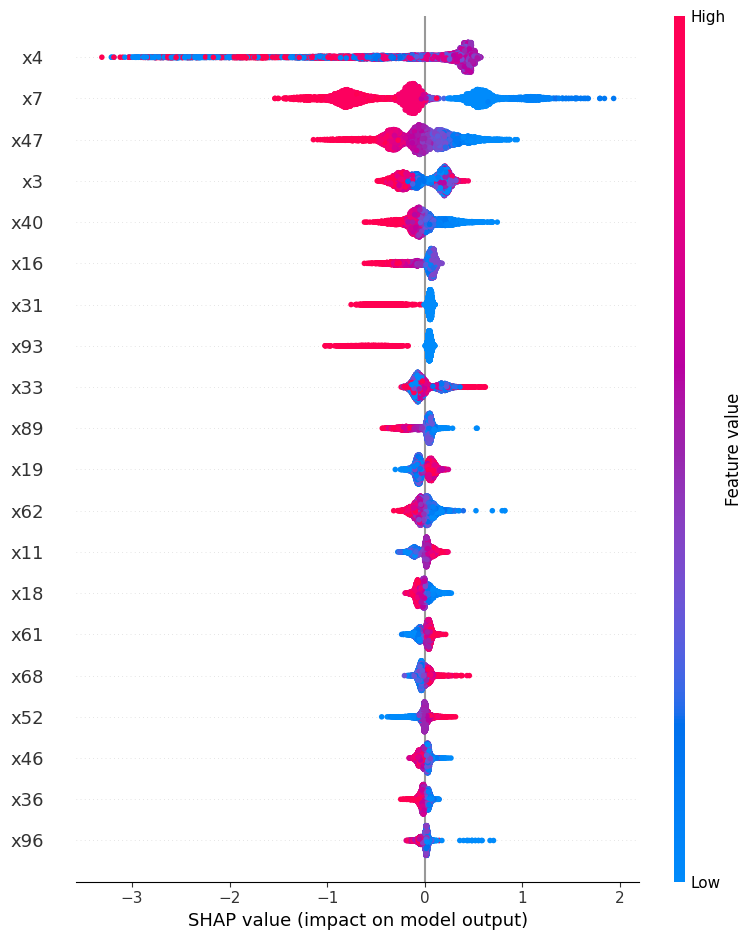

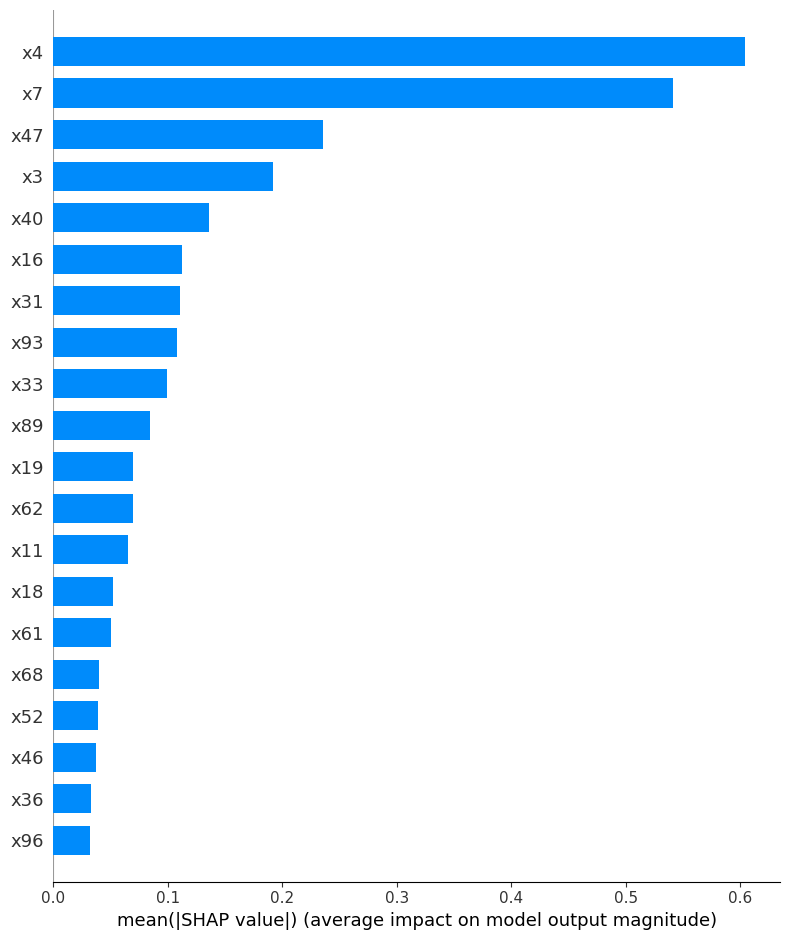

In [27]:
# Create TreeExplainer for XGBoost
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

# Summary Plot - Shows impact of each feature
shap.summary_plot(shap_values, X_test, plot_type="dot", show=True)

# Optional: Bar plot version (aggregated mean SHAP values)
shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)

## Dot Plot/Beeswarm
#### In dot plot or Beeswarm, each dot is one row from X_test
#### Each dot represents one prediction for one sample, showing how much a feature contributed to the model’s output.
#### Color shows the value of the feature : red = high, blue = low
#### X-axis : SHAP value (positive = pushes prediction towards class 1, negative = towards 0)
#### Ordering : Feature ranked by overall importance
#### Features at the top X4, X7 and X47 are the most influential across the dataset.

## Bar Plot
#### Shows mean absolute SHAP value for each feature - a measure to understand the overall importance.
#### The longer the bar, the more impact that feature has on the model’s predictions across all samples.
#### x4, x7, x47 are the most important features, contributing the most to the model's output.
#### Unlike the dot plot, this graph doesn't show the direction of influence, only magnitude.
#### This is useful for quickly identifying the top drivers behind the model’s decisions.
#### It helps with feature selection, interpretation, and explaining the model to non-technical stakeholders.


Metrics for Gradient Boosting
Accuracy:  0.8629
Precision: 0.6235
Recall:    0.0888
F1 Score:  0.1555
AUC Score: 0.7950

Confusion Matrix - Gradient Boosting:
[[6802   61]
 [1036  101]]


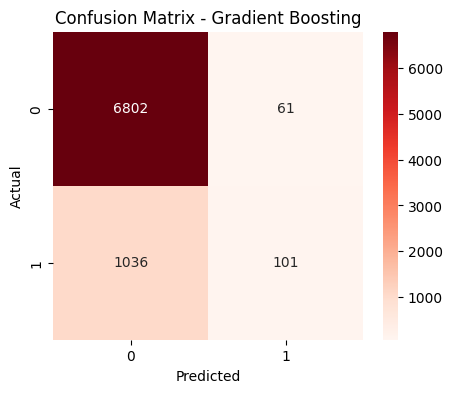

Classification Report - Gradient Boosting:
              precision    recall  f1-score   support

           0       0.87      0.99      0.93      6863
           1       0.62      0.09      0.16      1137

    accuracy                           0.86      8000
   macro avg       0.75      0.54      0.54      8000
weighted avg       0.83      0.86      0.82      8000



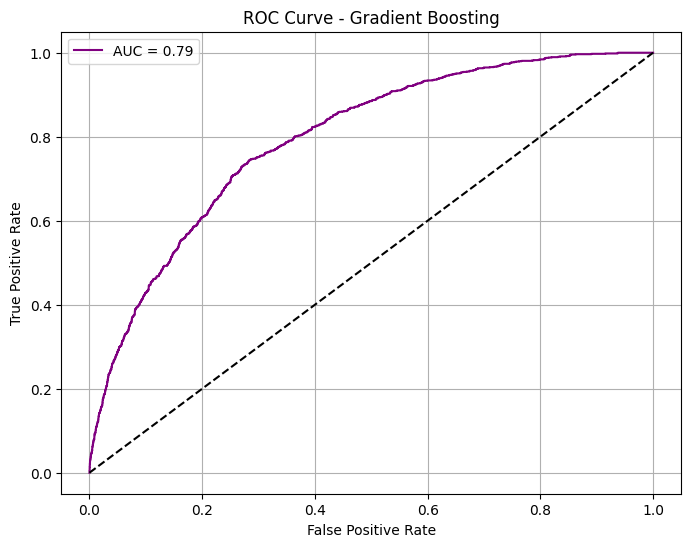


Top 3 Important Features:
x7     0.290490
x4     0.240640
x47    0.101709
dtype: float64


In [28]:
# Train Gradient Boosting Classifier
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)

# Predict
y_pred_gb = gb.predict(X_test)
y_proba_gb = gb.predict_proba(X_test)[:, 1]

# Evaluation Metrics
print("Metrics for Gradient Boosting")
accuracy = accuracy_score(y_test, y_pred_gb)
print(f"Accuracy:  {accuracy:.4f}")
precision = precision_score(y_test, y_pred_gb, zero_division=0)
print(f"Precision: {precision:.4f}")
recall = recall_score(y_test, y_pred_gb, zero_division=0)
print(f"Recall:    {recall:.4f}")
f1 = f1_score(y_test, y_pred_gb, zero_division=0)
print(f"F1 Score:  {f1:.4f}")
auc = roc_auc_score(y_test, y_proba_gb)
print(f"AUC Score: {auc:.4f}")

# Confusion matrix
print("\nConfusion Matrix - Gradient Boosting:")
cm_gb = confusion_matrix(y_test, y_pred_gb)
print(cm_gb)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix - Gradient Boosting")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Classification Report - Gradient Boosting:")
print(classification_report(y_test, y_pred_gb))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_gb)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}", color='purple')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Gradient Boosting")
plt.legend()
plt.grid()
plt.show()

# Top 3 Important Features
feature_importance = pd.Series(gb.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 3 Important Features:")
print(feature_importance.head(3))




In [29]:

results = []

# Logistic Regression

accuracy = accuracy_score(y_test, y_pred_lr)
precision = precision_score(y_test, y_pred_lr, zero_division=0)
recall = recall_score(y_test, y_pred_lr, zero_division=0)
f1 = f1_score(y_test, y_pred_lr, zero_division=0)
auc = roc_auc_score(y_test, y_proba_lr)

results.append({
    "Model": "Logistic Regression",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "AUC Score": auc
})

# Decision Tree

accuracy = accuracy_score(y_test, y_pred_dt)
precision = precision_score(y_test, y_pred_dt, zero_division=0)
recall = recall_score(y_test, y_pred_dt, zero_division=0)
f1 = f1_score(y_test, y_pred_dt, zero_division=0)
auc = roc_auc_score(y_test, y_proba_dt)


results.append({
    "Model": "Decision Tree",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "AUC Score": auc
})

# Random Forest

accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf, zero_division=0)
recall = recall_score(y_test, y_pred_rf, zero_division=0)
f1 = f1_score(y_test, y_pred_rf, zero_division=0)
auc = roc_auc_score(y_test, y_proba_rf)


results.append({
    "Model": "Random Forest",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "AUC Score": auc
})

# XGBoost

accuracy = accuracy_score(y_test, y_pred_xg)
precision = precision_score(y_test, y_pred_xg, zero_division=0)
recall = recall_score(y_test, y_pred_xg, zero_division=0)
f1 = f1_score(y_test, y_pred_xg, zero_division=0)
auc = roc_auc_score(y_test, y_proba_xg)


results.append({
    "Model": "XGBoost",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "AUC Score": auc
})

# Gradient Boosting

accuracy = accuracy_score(y_test, y_pred_gb)
precision = precision_score(y_test, y_pred_gb, zero_division=0)
recall = recall_score(y_test, y_pred_gb, zero_division=0)
f1 = f1_score(y_test, y_pred_gb, zero_division=0)
auc = roc_auc_score(y_test, y_proba_gb)

results.append({
    "Model": "Gradient Boosting",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "AUC Score": auc
})

# Final comparison table
comparison_df = pd.DataFrame(results)
print("Model Comparison Table:")
print(comparison_df)



Model Comparison Table:
                 Model  Accuracy  Precision    Recall  F1 Score  AUC Score
0  Logistic Regression  0.745250   0.252064  0.402814  0.310088   0.652261
1        Decision Tree  0.773000   0.228617  0.251539  0.239531   0.555465
2        Random Forest  0.858000   0.555556  0.004398  0.008726   0.720704
3              XGBoost  0.863125   0.590517  0.120493  0.200146   0.793561
4    Gradient Boosting  0.862875   0.623457  0.088830  0.155504   0.794971


#### Gradient Boosting is the best-performing model overall for this dataset because it has Highest AUC Score (0.7950), Best Precision (0.6235), Competitive Accuracy (0.8629).

#### It gives the highest AUC score, the best precision, and has accuracy very close to the top models.
#### If we need a model that's easier to understand or faster to train, Logistic Regression is a good option.
#### But if our goal is to get the most accurate predictions, Gradient Boosting is the way to go.
